In [172]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import pickle
import matplotlib.pyplot as plt
from matplotlib import style

from random import seed
from random import randint

In [173]:
seed(100)

## Dataset
https://archive.ics.uci.edu/ml/datasets/Student+Performance

## Problem
Predict a final grade based on other data about the student

In [174]:
data = pd.read_csv("data.csv", sep=";")

In [175]:
data.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'G3'],
      dtype='object')

In [176]:
data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


## Data Cleaning
Trim down the columns so the important determining factors for the final grade are used and irrelevant data is filtered out.

The first and second period grades are important factors.

Other factors which make sense to include are the weekly study time, number of past class failures, and number of school absences.

In [177]:
trimmed_data = data[["G1", "G2", "G3", "studytime", "failures", "absences"]]

In [178]:
trimmed_data.head()

,G1,G2,G3,studytime,failures,absences
0,5,6,6,2,0,6
1,5,5,6,2,0,4
2,7,8,10,2,3,10
3,15,14,15,3,0,2
4,6,10,10,2,0,4


### Plot
See how the number of previous failures affect the final grade

In [179]:
style.use("ggplot")

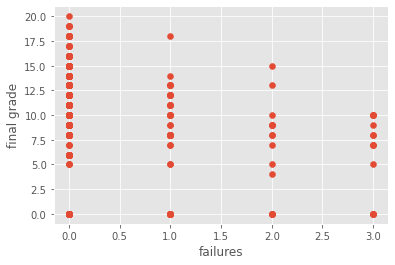

In [180]:
plot = "failures"

plt.scatter(trimmed_data[plot], data["G3"])
plt.xlabel(plot)
plt.ylabel("final grade")

plt.show()

### Define the features and the labels

In [181]:
predicted_col = "G3"

In [182]:
X_features = np.array(trimmed_data.drop([predicted_col], axis=1))

In [183]:
y_labels = np.array(trimmed_data[predicted_col])

In [184]:
X_features[:6]

array([[ 5,  6,  2,  0,  6],
       [ 5,  5,  2,  0,  4],
       [ 7,  8,  2,  3, 10],
       [15, 14,  3,  0,  2],
       [ 6, 10,  2,  0,  4],
       [15, 15,  2,  0, 10]])

In [185]:
y_labels[:6]

array([ 6,  6, 10, 15, 10, 15])

## Fitting the data
By training the linear regression model, we hope to come up with a line that can predict any student's final grade given the chosen factors.

First, the line must be tweaked to fit well on the training data.

Next, evaluate the performance of the line on test data. Save the line which has the best performance on test data.

Because not all data will be like the given test data, the line which had the best performance on test data is not necessarily the best predictor for other data. Set aside a portion of the data on hand as validation data to see how the model performs on data it has not seen.

## Model Parameters
Linear regression is just a best fit line, which can be modelled by `y = mx + b`

Slope: m


This is an array because there should be a scalar value per factor.


Each scalar value determines the rise in the predicted value per 1 unit rise in each factor.

Y-intercept: b

Coefficient of determination

R-squared represents the proportion of variation in the label which can be explained by the features, this shows the strength of the relationship between the features and the label. This measure can range from 0 to 1.

This statistical measures is a square of the coefficient of correlation (which is calculated by a mathmatical formula). Correlation coefficient can range from 1 (strong positive relationship) to -1 (strong negative relationship). If the coefficient of correlation is 0, there is no relationship.

In [186]:
class Predictor(object):
    predictions_dict = {
        "actual": [],
        "features": [],
        "expected": [],
        "difference": []
    }
    
    def __init__(self, model):
        self.model = model
    
    def getPredictions(self, val_features, val_labels):
        predictions = self.model.predict(val_features)

        for x in range(len(predictions)):
            actual_pred = predictions[x]
            expected = val_labels[x]

            Predictor.predictions_dict["actual"].append(actual_pred)
            Predictor.predictions_dict["features"].append(val_features[x])
            Predictor.predictions_dict["expected"].append(expected)
            Predictor.predictions_dict["difference"].append(abs(expected - actual_pred))

        predictions_df = pd.DataFrame(Predictor.predictions_dict)
        return np.mean(Predictor.predictions_dict["difference"])

In [187]:
def findBestModel():
    best = 0
    
    for _ in range(20):
        """Define training, test, and validations sets"""
        split_seed = randint(0, 9999)
        
        # 80% training, 20% test
        X_train, X_test, y_train, y_test = train_test_split(
            X_features, y_labels, test_size = 0.2, random_state=split_seed)
        
        # 65% training 0.8 * (1 - 0.1875), 20% test, 15% validation
        X_train, X_val, y_train, y_val = train_test_split(
            X_train, y_train, test_size=0.1875, random_state=split_seed) # 0.1875 x 0.8 = 0.15
        
        # train the model with training set
        linear = LinearRegression()
        linear.fit(X_train, y_train)

        """r_squared = coefficient of determination"""
        # shows the strength of the relationship between the features and the label
        # range from 0 to 1
        r_squared = linear.score(X_test, y_test)
        if r_squared > best:
            best = r_squared
            best_X_val = X_val
            best_y_val = y_val
            with open("model.pickle", "wb") as f:
                pickle.dump(linear, f)
     
    best_linear_model = pickle.load(open("model.pickle", "rb"))
    predictor = Predictor(best_linear_model)
    
    print('Average deviation during validation', predictor.getPredictions(best_X_val, best_y_val))
    print('Slope', best_linear_model.coef_)
    print('Y-intercept', best_linear_model.intercept_)
    print('R-Squared', best)

In [188]:
findBestModel()

Average deviation during validation 1.2011518213092736
Slope [ 0.16451254  1.00131612 -0.17724632 -0.19494512  0.04109643]
Y-intercept -2.0336316307203557
R-Squared 0.9199629645669747
